# TeslaMax Optimization

Teslamax model:

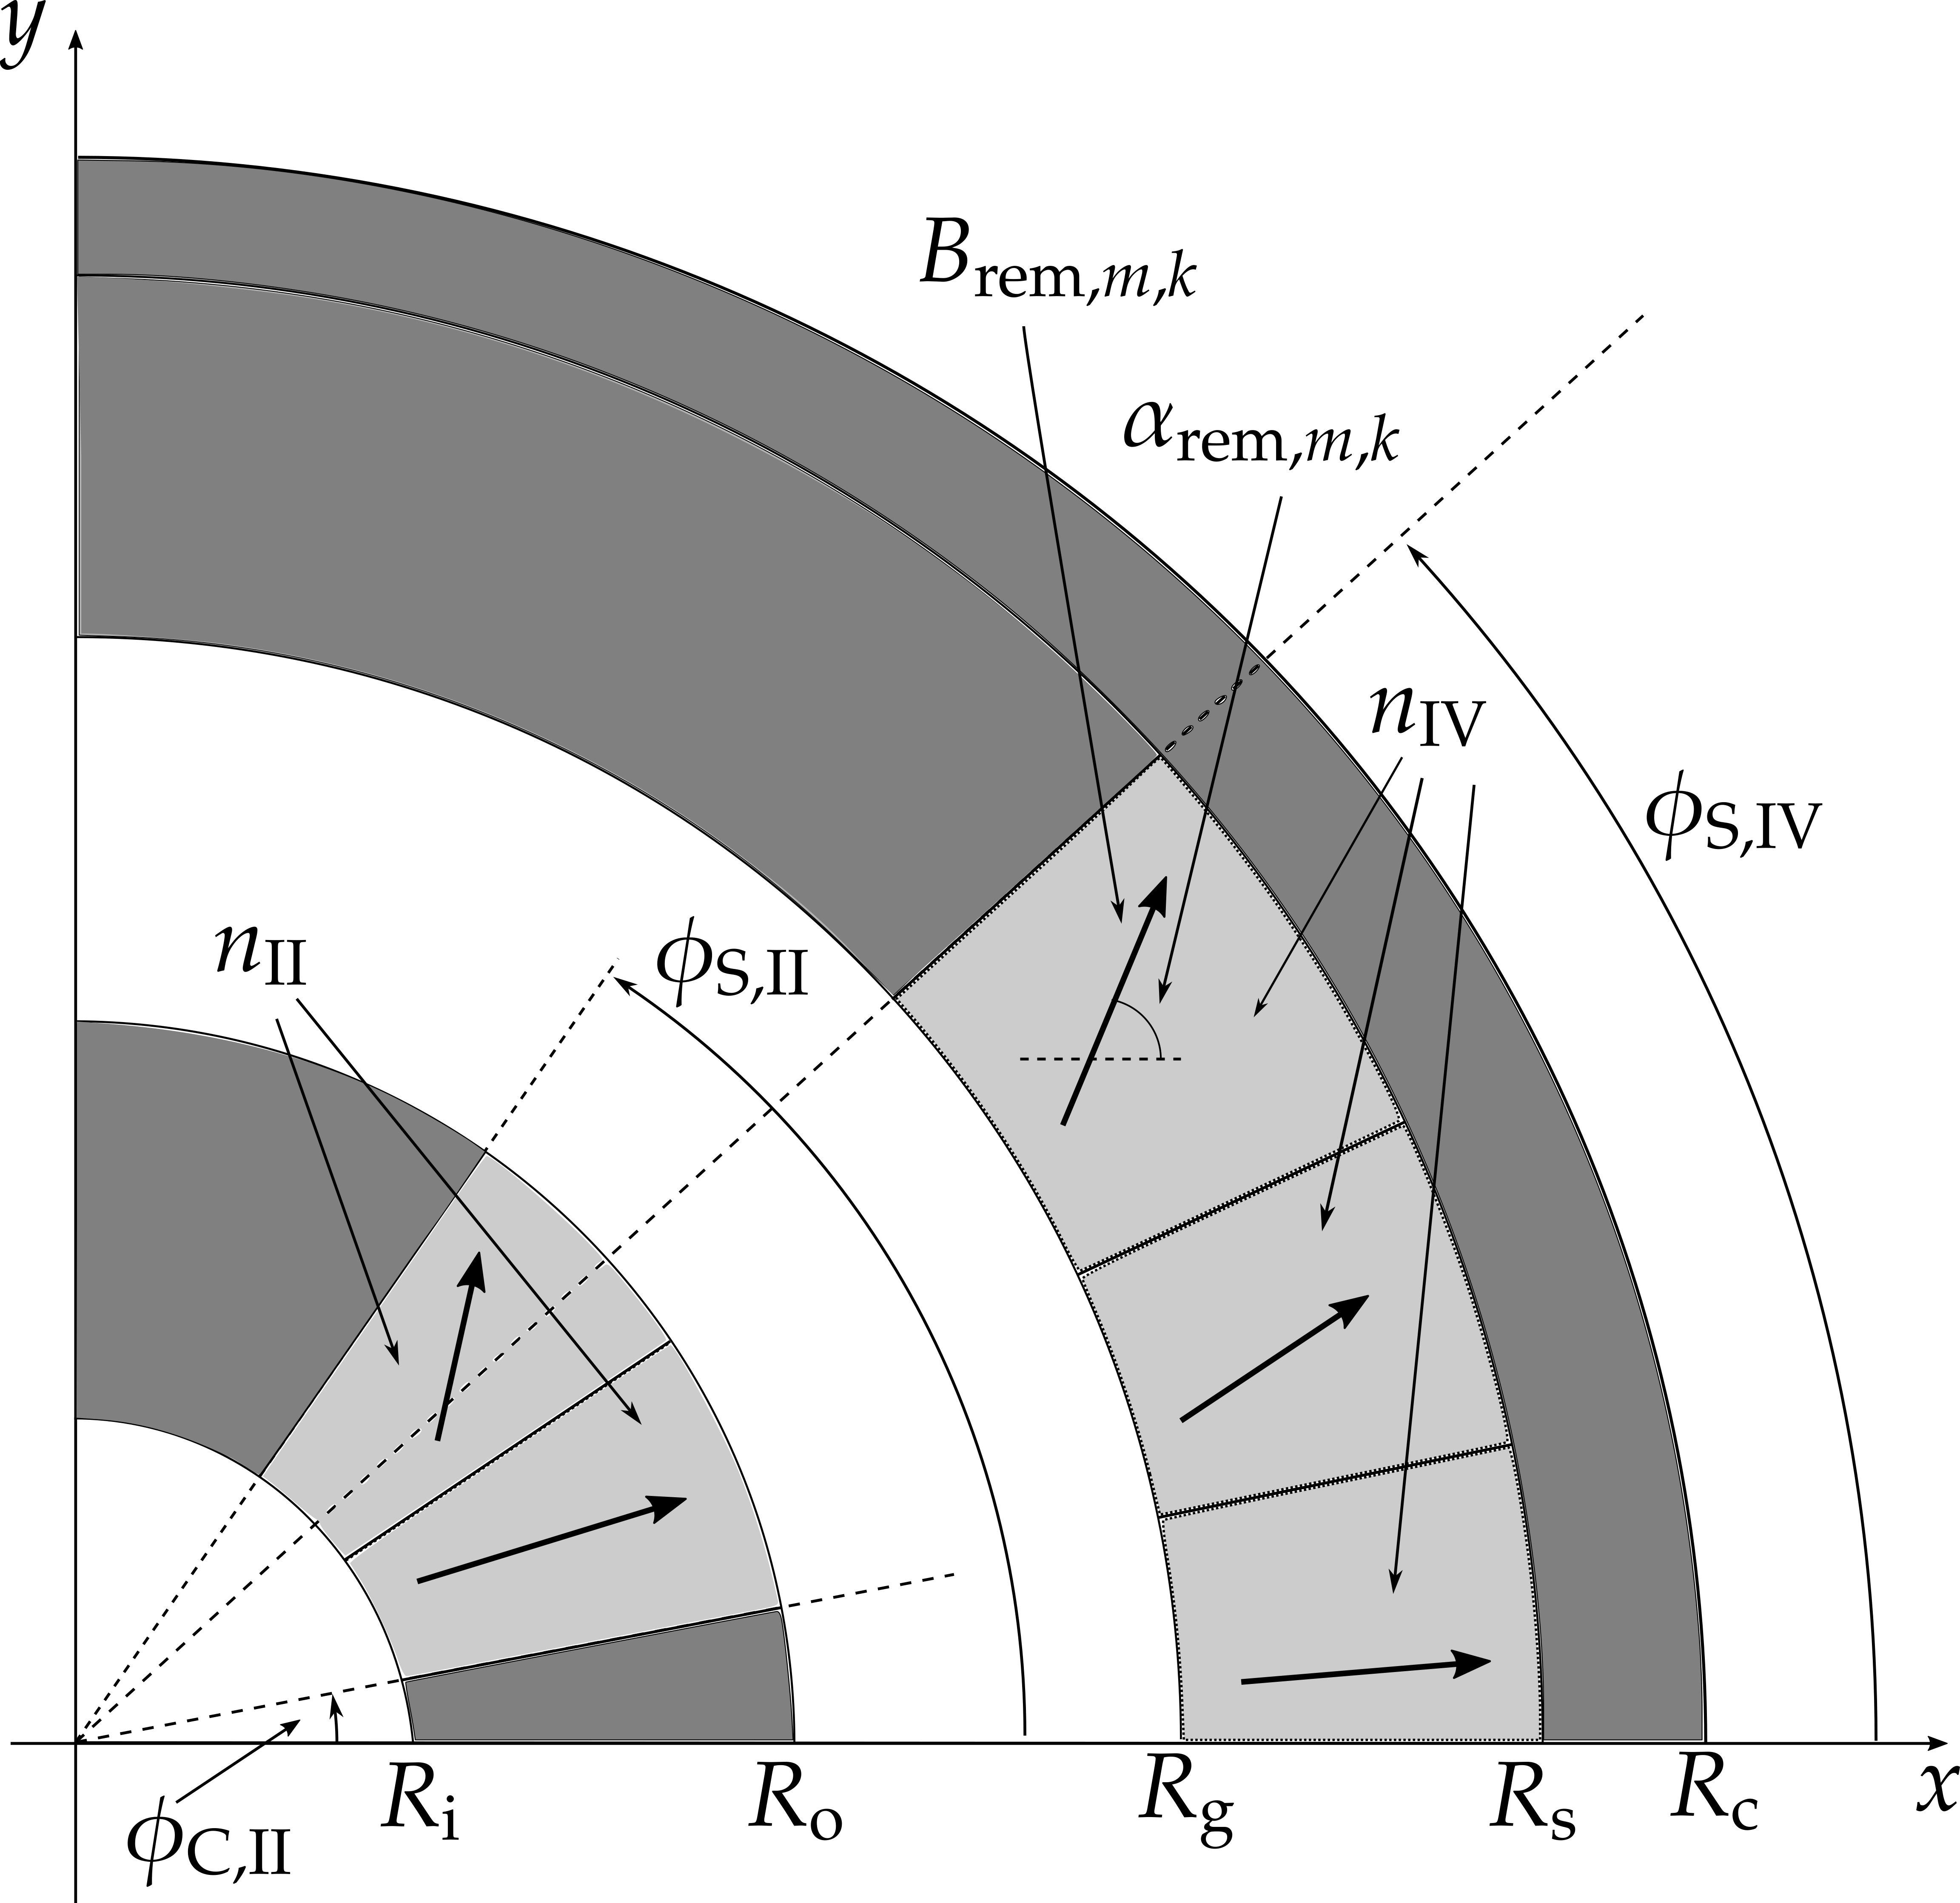

In [1]:
from IPython.display import Image
Image("figures/teslamax.png",width=500)

We are intererested in finding the optimal set of remanence angles $\alpha_{\mathrm{rem},m,k}$ that will maximize some metric in the air gap.

In [2]:
from pathlib import Path
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
from pandas import Series, DataFrame
import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel



mpl_params = {'text.usetex': True,
              'font.family': 'serif',
              'font.serif': 'Computer Modern',
              'text.latex.preamble': [r'\usepackage{engsymbols}',
                                      r'\usepackage{magref}',
                                      r'\usepackage{siunitx}']}
matplotlib.rcParams.update(mpl_params)

In [3]:
FIGSIZE_CM = 20
FIGSIZE_INCHES = FIGSIZE_CM / 2.54

FONTSIZE = 20



PAPER_FILE_PATH = Path('.')
FIGURES_DIR_NAME = "figures"
FIG_FILE_PATH = PAPER_FILE_PATH / Path(FIGURES_DIR_NAME)


PLOT_EXTENSION = ".png"

DPI = 800

In [16]:
os.chdir(str(Path.home() / "code" / "TeslaMax"))

In [17]:
os.getcwd()

'C:\\Users\\fapfor\\code\\TeslaMax'

In [6]:
def save_figure(fig,name):
    """
    Save the 'fig' Figure object as 'name' (with extension PLOT_EXTENSION), inside FIG_FILE_PATH,
    and close the figure"""
    
    
    file_path = str(FIG_FILE_PATH / (name + PLOT_EXTENSION))
    fig.savefig(file_path,dpi=DPI,bbox_inches='tight')

## AMR simulations

To help determine the best magnetic profile for an AMR device, simulations using the AMR model from Trevizoli (2015) were performed, and can be found in [this repository](https://github.com/PoloMag/paper-magnetic-profiles). We wish then to design the magnet to be able to provide the desired profile.

All simulations considered a ramp profile like this one:

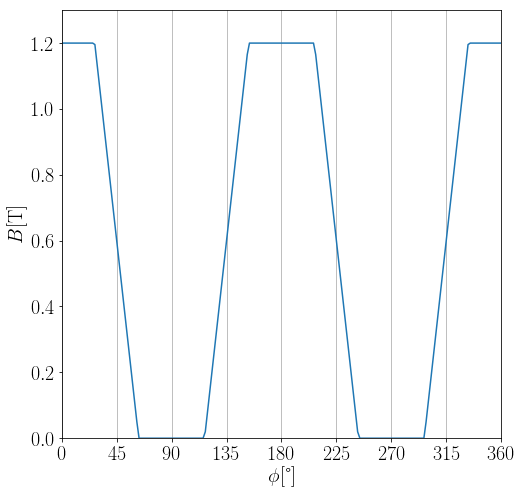

In [7]:
%matplotlib inline
plt.rc('font',size=FONTSIZE)

ramp_profile_fig = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
ramp_profile_axes = ramp_profile_fig.add_subplot(111)

B_high = 1.2
B_low = 0.0
field_fraction = 0.3

phi_vector = np.linspace(0,360,200)
B_ramp_vector = teslamax.calculate_ramp_profile(phi_vector,B_high,B_low,field_fraction)

ramp_profile_axes.plot(phi_vector,B_ramp_vector)
ramp_profile_axes.set_xlim(0,np.max(phi_vector))
ramp_profile_axes.set_xticks(np.linspace(0,np.max(phi_vector),9))
ramp_profile_axes.xaxis.grid(True)
ramp_profile_axes.set_ylim(0,B_high+0.1)
ramp_profile_axes.set_yticks(np.arange(0,B_high+0.2,0.2))
ramp_profile_axes.set_xlabel(r'$\phi [\si{\degree}]$')
ramp_profile_axes.set_ylabel(r'$B [\si{\tesla}]$')


The following parameters were kept fixed in all simulations:

In [8]:
FIXED_PARAMETERS_AMR = {
    "D_p[m]": 0.5e-3,
    "L[m]": 100e-3,
    "W[m]": 25e-3,
    "H[m]": 20e-3,
    "N_r[]": 11,
    "T_H[K]": 298,
    "dT[K]": 20,
"t_csg[m]": 1e-3,
"t_air[m]": 0.5e-3,
"casing_material": "G10"
}

FIXED_PARAMETERS_AMR["hgap[m]"] = FIXED_PARAMETERS_AMR["H[m]"] + 2*(FIXED_PARAMETERS_AMR["t_csg[m]"] + 
                                                                    FIXED_PARAMETERS_AMR["t_air[m]"])

In [9]:
# we print in the Series format for nicer output
print(Series(FIXED_PARAMETERS_AMR))

D_p[m]             0.0005
H[m]                 0.02
L[m]                  0.1
N_r[]                  11
T_H[K]                298
W[m]                0.025
casing_material       G10
dT[K]                  20
hgap[m]             0.023
t_air[m]           0.0005
t_csg[m]            0.001
dtype: object


Thermal losses were included in the simulations.

By varying the field fraction $F_M$ (the fraction of the cycle where the field is at the maximum level) and the maximum magnetic field, the following map can be generated, for a combination of frequency, utilization and blow fraction:

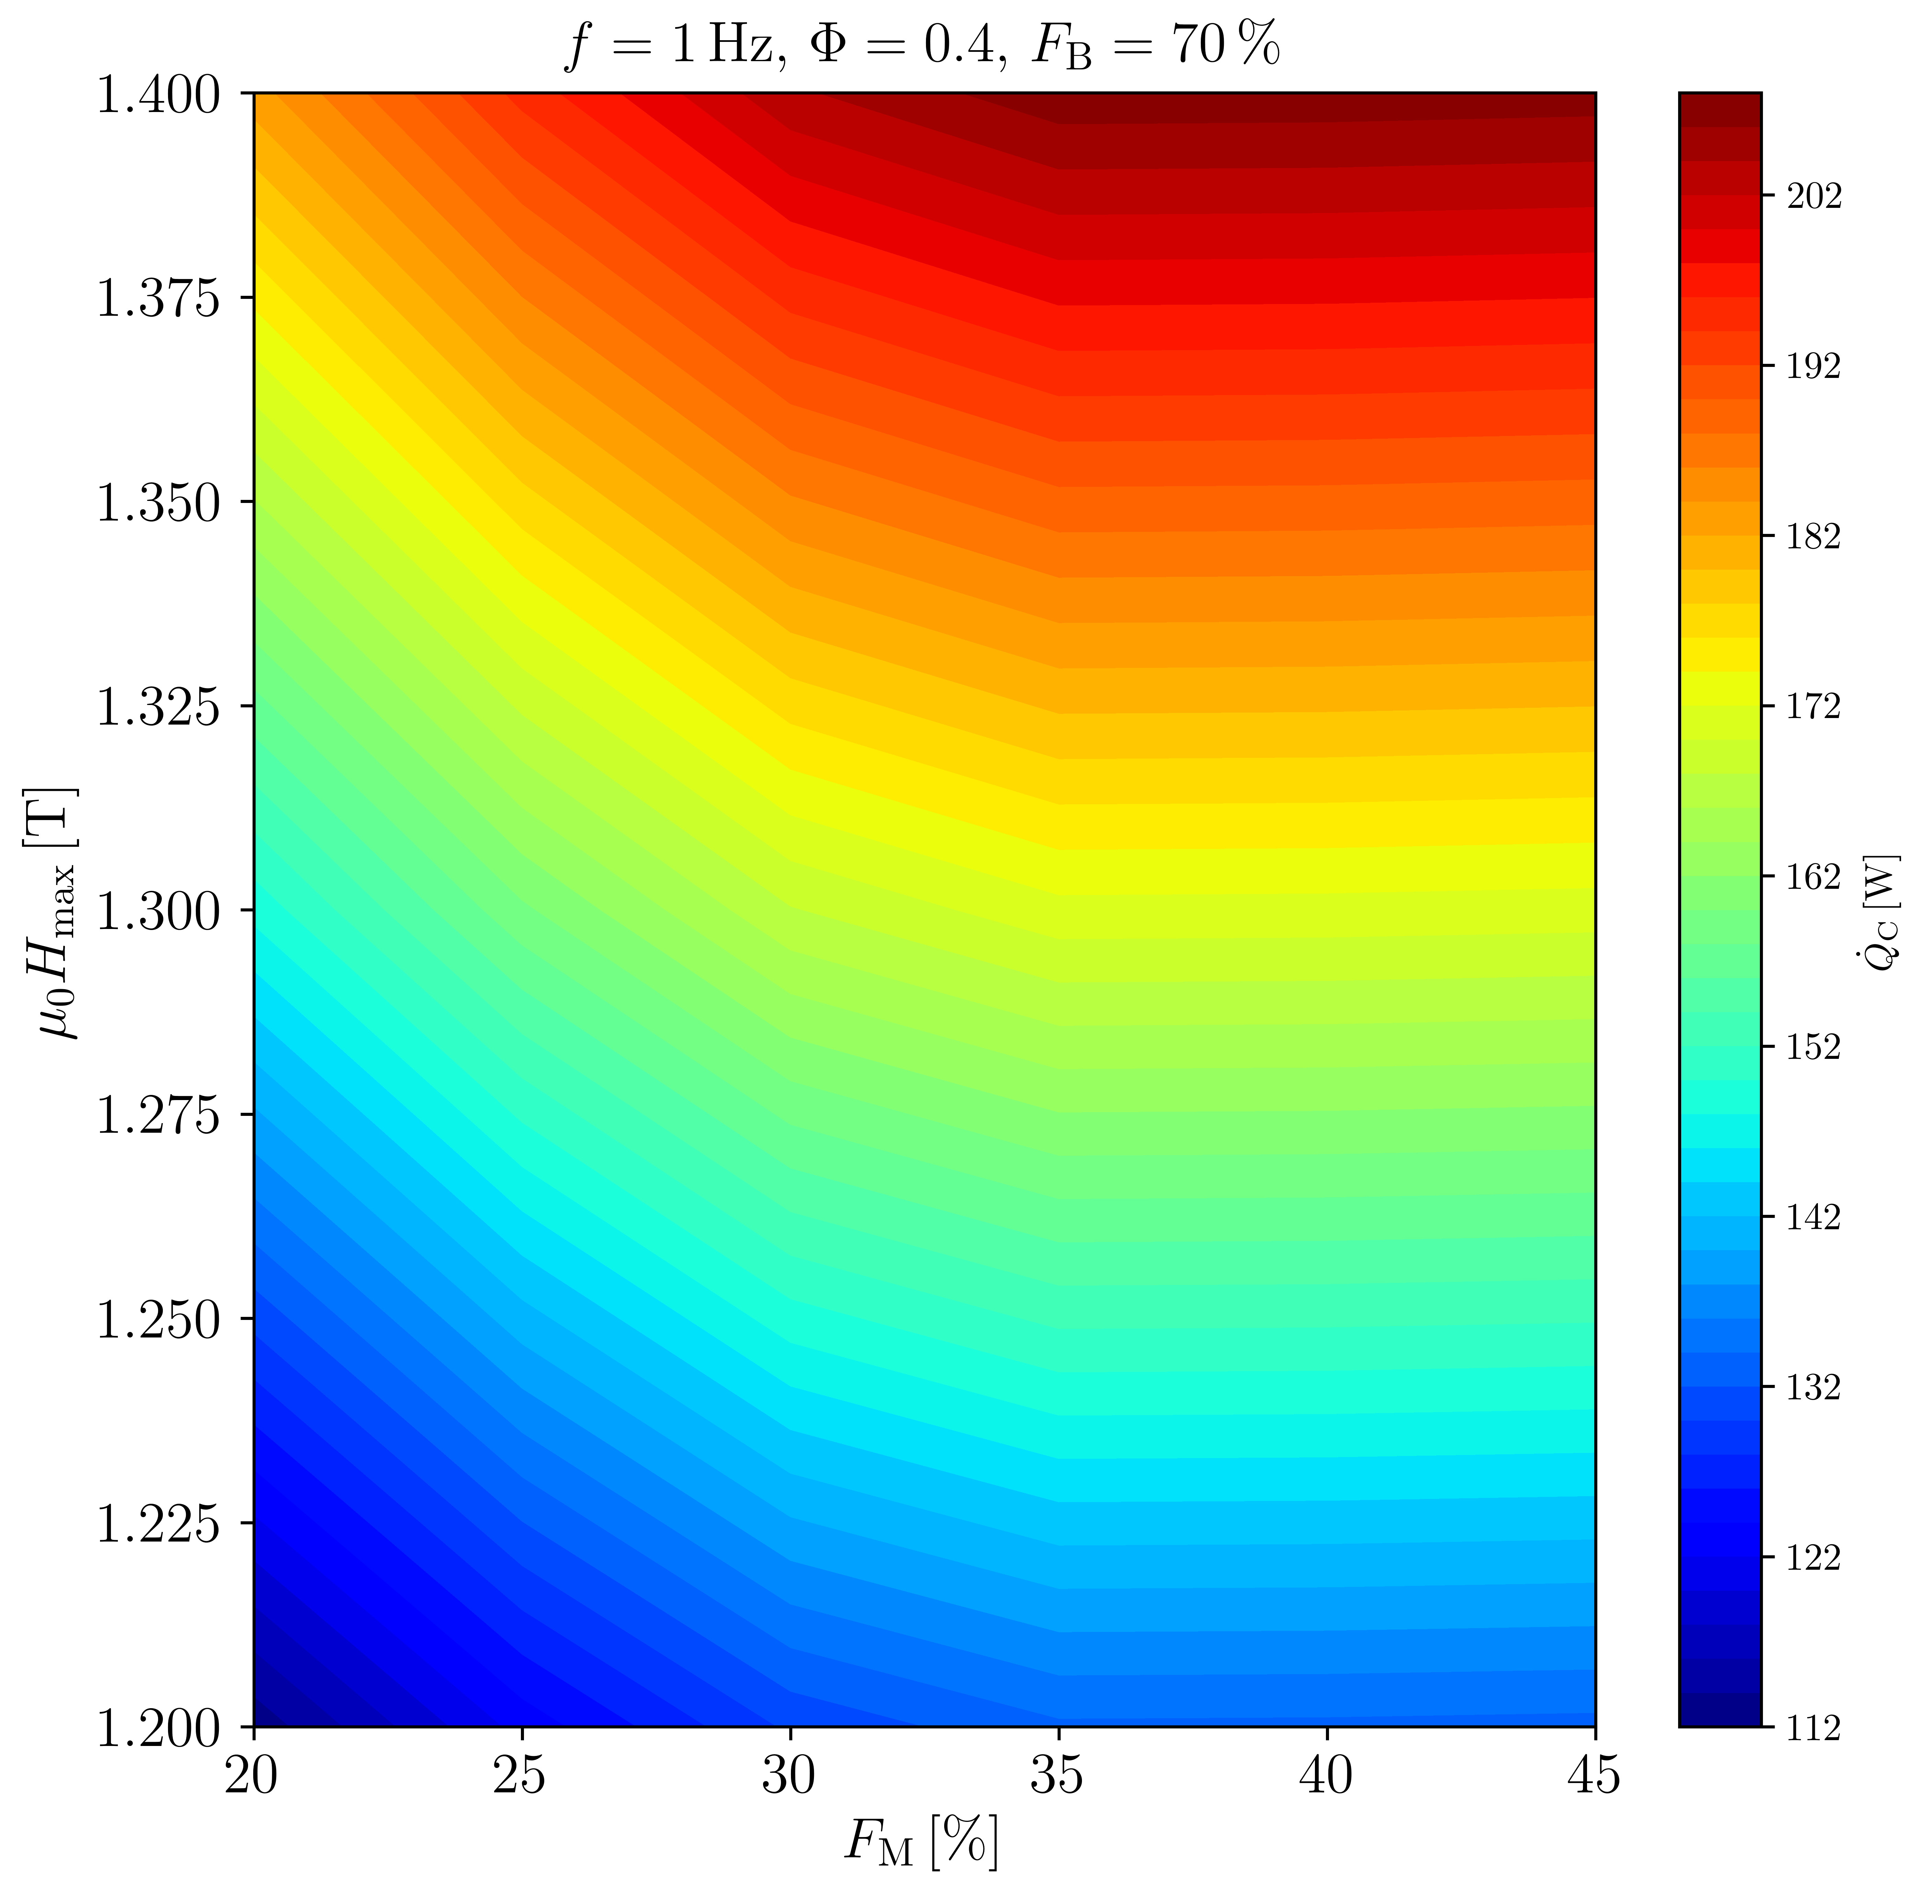

In [10]:
Image("figures/Qc_ramp_map_f_1_Phi_40_FB_70.png",width=500)

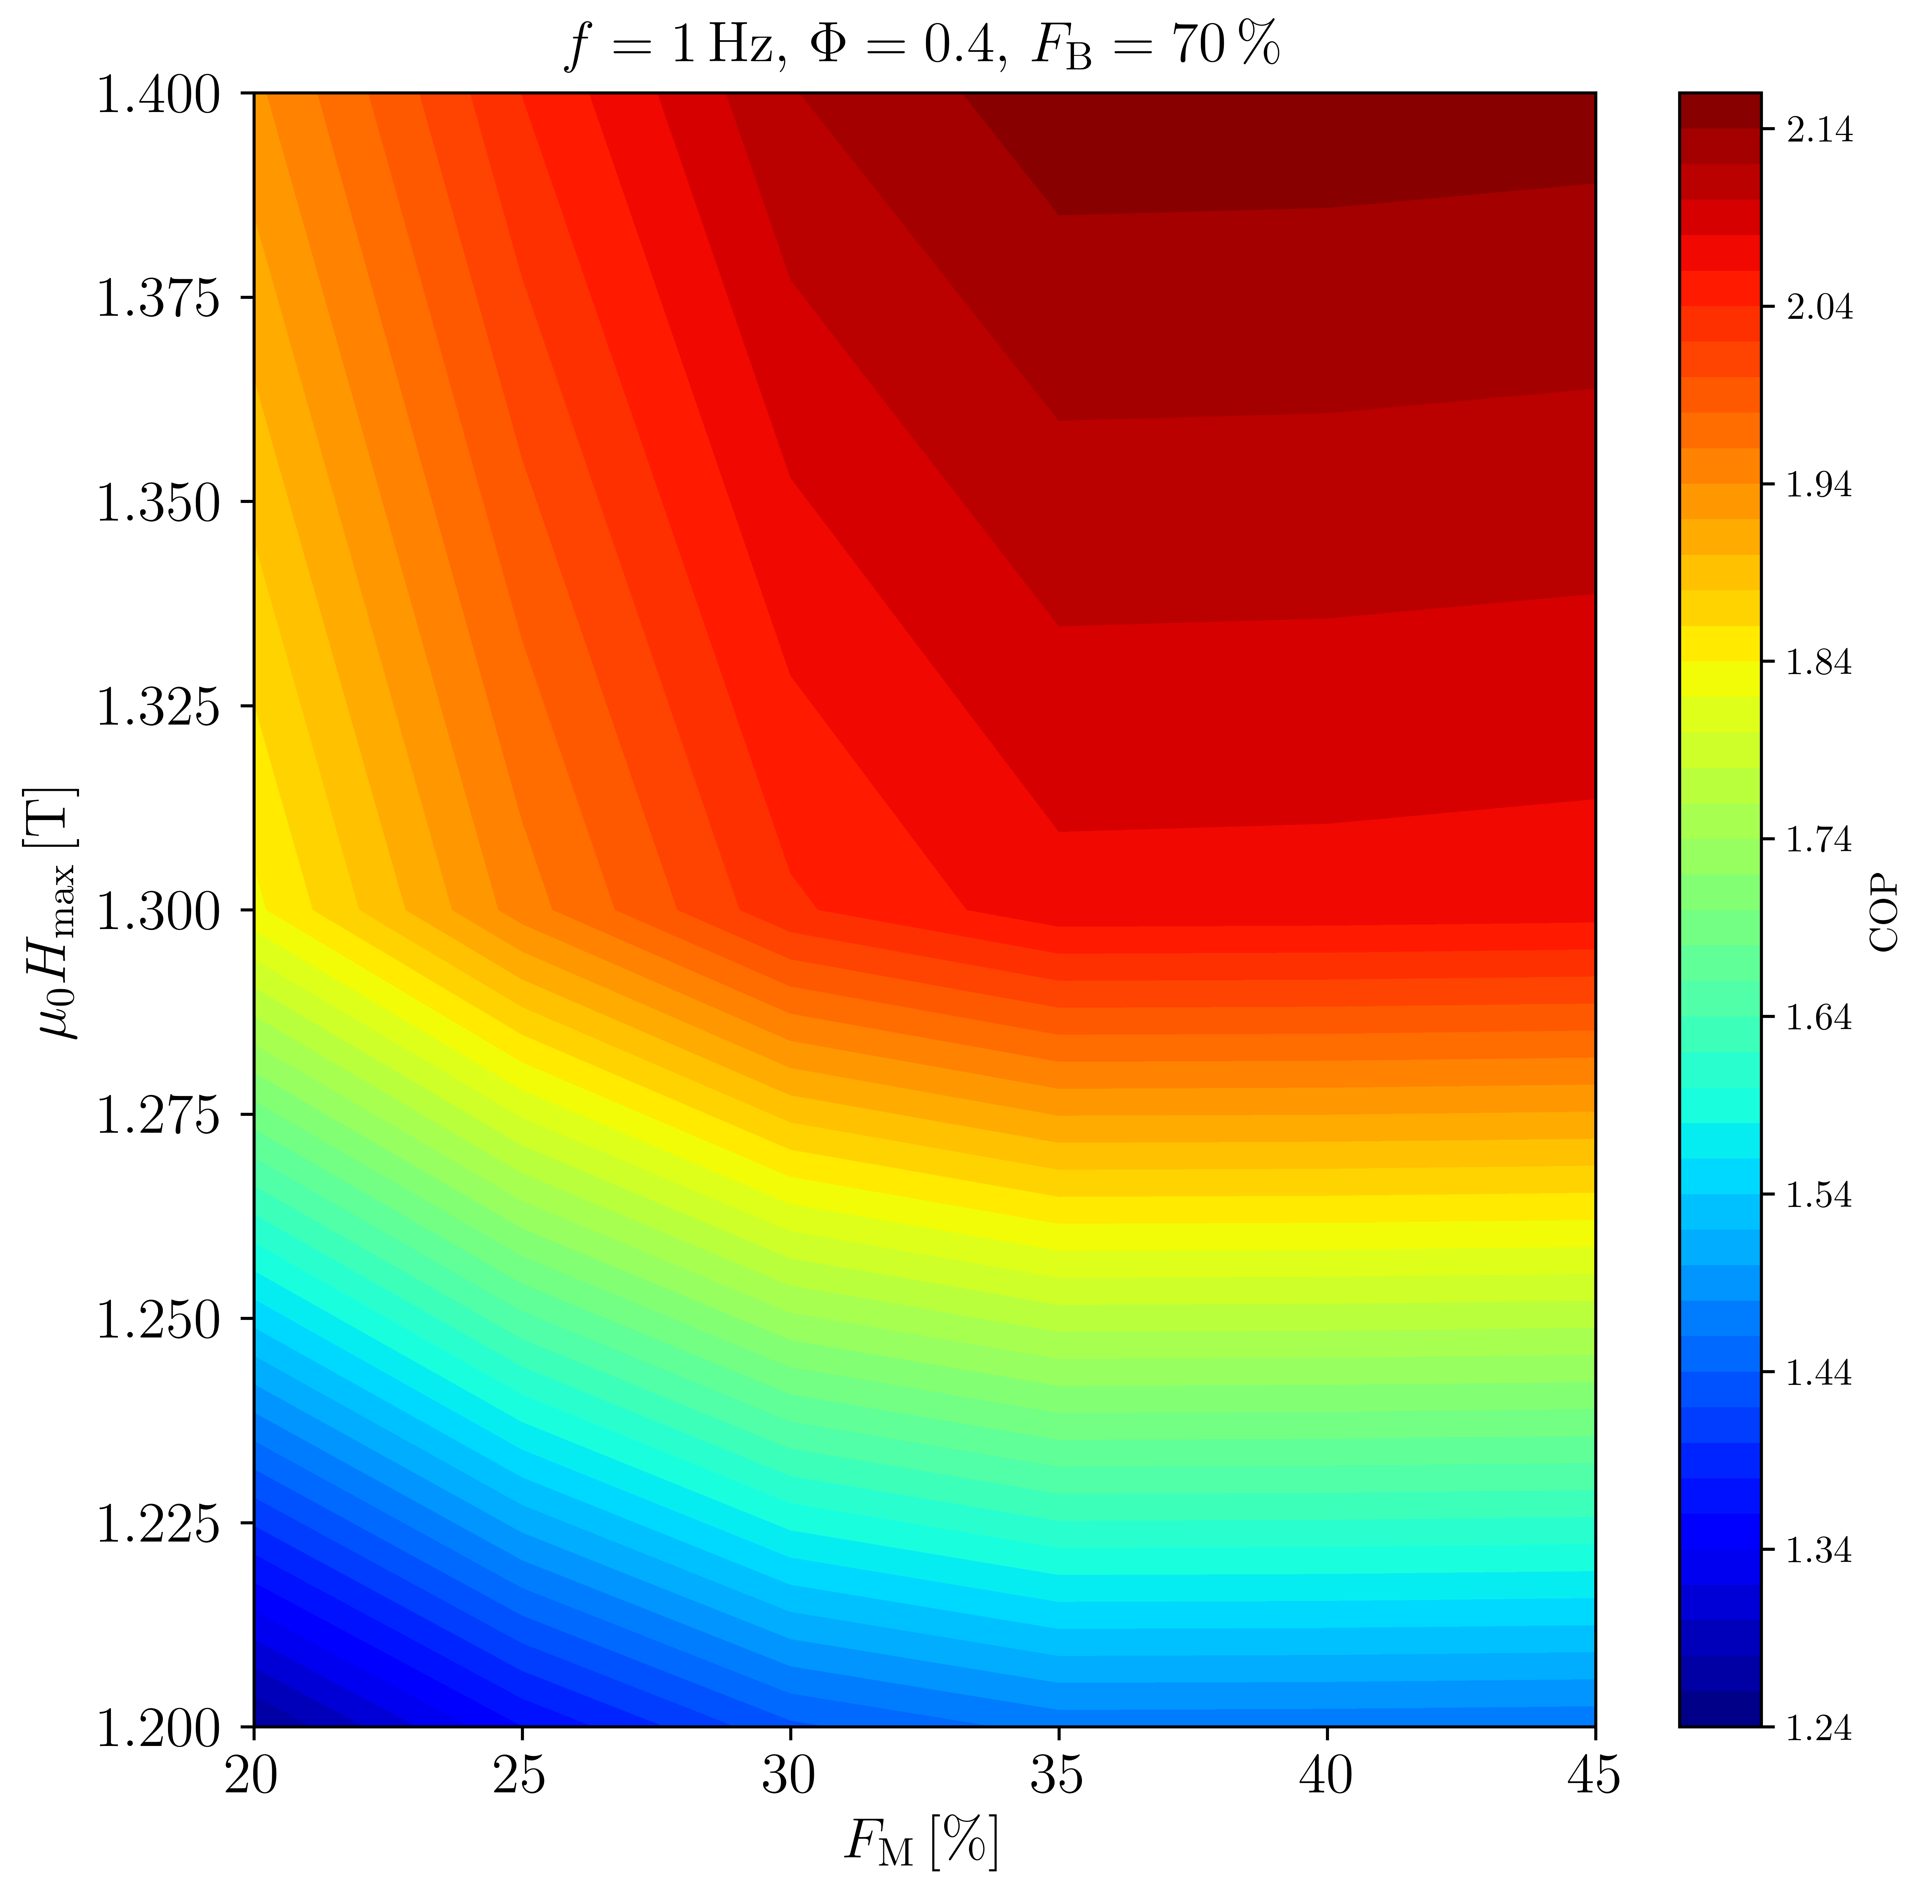

In [11]:
Image("figures/COP_ramp_map_f_1_Phi_40_FB_70.png",width=500)

Notice how the results are sensitive to the magnitude of the field. It is more advantangeous to keep the field at 1.4 T during  30% of the cycle than keeping the field at 1.2 T for the entire cycle.

Our current estimative for the cooling capacity for the wine cooler is 180 W @ 0 K and 100 W @ 25 K, with the highest possible COP. Since our simulations were made for a span of 20 K, let us define a virtual operating condition of 170 W @ 20 K, with COP > 1.5. From the above figure, we can select three pairs of $(B\ped{max}, F\ped{M})$:

1. 1.275 T for 45% of the time
2. 1.300 T for 35% of the time
3. 1.400 T for 25% of the time

## Objective function

We consider that the magnetic profile is a good representation of what the regenerators experience, and it is what is used as an input to AMR models. Therefore, the optimization procedure that is developed here is denoted *profile matching*: we calculate the optimal remanence angles for each magnet segments, such that the deviation between the resulting profile and a *target* ramp profile is minimized:

\begin{equation}
\mathcal{K}(\nvector{x}) = \frac{1}{2\pi}\left(\int_0^{2\pi}\left(\average{B}(\phi,\nvector{x}) - \average{B}\ped{ramp} (\phi,B\ped{l},B\ped{h},F\ped{M})\right)^{2}\diffd{\phi}\right)
\end{equation}

where $\average{B}(\phi,\nvector{x})$ is the magnetic profile calculated at position $\phi$ when the remanence angles are represented by $\nvector{x}$, and $\average{B}\ped{ramp} \left(\phi,B\ped{l},B\ped{h},F\ped{M})\right)$ is the ramp profile at angle $\phi$, between plateaus $B\ped{l}$ and $B\ped{h}$ for the low and high field regions, with a high field fraction $F\ped{M}$ (the fraction of the entire cycle where the field is at the high level).

## Optimization using Scipy

In [12]:
def optimize_and_plot_ramp(B_high,field_fraction,params):
    """
    Run the TeslaMax optimization procedure, trying to match the profile
    to a ramp profile between 0 and 'B_high' with 'field_fraction', using the
    parameters in the dictionary 'params'.
    
    Plot and save the figures, and return the vector of optimal remanence directions
    """
    
    tmpd = TeslaMaxPreDesign(params)
    
    target_function = teslamax.calculate_ramp_profile
    
    B_low = 0.0
    
    target_args = (B_high,B_low,field_fraction)

    alpha_B_rem_g = tmpd.get_optimal_remanence_angles(target_function,target_args)
    cost_function = tmpd.calculate_functional_target(alpha_B_rem_g,
                                                    target_function,
                                                    target_args)

    # plot results   
    plt.rc('font',size=FONTSIZE)

    profile_fig_g = plt.figure(figsize=(FIGSIZE_INCHES,FIGSIZE_INCHES))
    profile_axes_g = profile_fig_g.add_subplot(111)
    
    teslamax_playground = str(Path.home() / "code" / "TeslaMax" / "teslamax-play" )
    
    tmm_g = TeslaMaxModel(tmpd,
                          alpha_B_rem_g,
                          path=teslamax_playground)
    tmm_g.run()
    phi_vector_g, B_vector_g = tmm_g.get_profile_data().T
    
    profile_axes_g.plot(phi_vector_g,B_vector_g)
    profile_axes_g.set_xlim(0,np.max(phi_vector_g))
    profile_axes_g.set_xticks(np.linspace(0,np.max(phi_vector_g),9))
    profile_axes_g.xaxis.grid(True)
    profile_axes_g.set_ylim(0,B_high+0.1)
    profile_axes_g.set_yticks(np.arange(0,B_high+0.2,0.2))
    profile_axes_g.set_xlabel(r'$\phi [\si{\degree}]$')
    profile_axes_g.set_ylabel(r'$B [\si{\tesla}]$')
    
    B_inst_vector = teslamax.calculate_ramp_profile(phi_vector_g,B_high,B_low,field_fraction)
    profile_axes_g.plot(phi_vector_g,B_inst_vector,'--')

    save_figure(profile_fig_g,"profile_optimized_B_%d_FM_%d" %(B_high*1000,field_fraction*100))
    
    return alpha_B_rem_g,cost_function
    

### 1.275 T for 45% of the time

In [13]:
params_optimization_1 = {"R_i": 0.015,
                "R_o": 0.060,
                "h_gap": FIXED_PARAMETERS_AMR["hgap[m]"],
                "R_s": 0.150,
                "h_fc": 0.010,
                "R_e": 0.3,
                "n_IV": 4,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

n_II = params_optimization_1["n_II"]
n_IV = params_optimization_1["n_IV"]

n = n_II + n_IV

B_rem = 1.4

# expand parameters to include remanence magnitudes for each segment
params_optimization_1 = teslamax.expand_parameters_from_remanence_array(B_rem*np.ones(n), 
                                                                      params_optimization_1, 
                                                                      "B_rem")




Optimal angles:
[  7.34794737  44.63147631   1.89021608   4.03153235  20.26552857
  43.12024006  97.74396484]
Value of the objective function:
0.561755770517
Wall time: 28min 8s


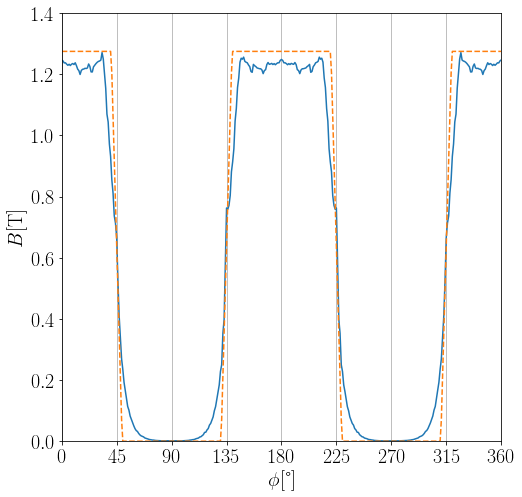

In [14]:
%%time
%matplotlib inline

B_high = 1.275
field_fraction = 0.45

alpha_B_rem_g_1, K_1 = optimize_and_plot_ramp(B_high,field_fraction,params_optimization_1)
print("Optimal angles:")
print(alpha_B_rem_g_1)
print("Value of the objective function:")
print(K_1)

### 1.300 T for 35% of the time

In [15]:
params_optimization_2 = {"R_i": 0.015,
                "R_o": 0.060,
                "h_gap": FIXED_PARAMETERS_AMR["hgap[m]"],
                "R_s": 0.150,
                "h_fc": 0.010,
                "R_e": 0.3,
                "n_IV": 4,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

n_II = params_optimization_2["n_II"]
n_IV = params_optimization_2["n_IV"]

n = n_II + n_IV

B_rem = 1.4

# expand parameters to include remanence magnitudes for each segment
params_optimization_2 = teslamax.expand_parameters_from_remanence_array(B_rem*np.ones(n), 
                                                                      params_optimization_2, 
                                                                      "B_rem")




Optimal angles:
[  2.61756314   8.14135092   0.           3.12876767  15.16697551
  42.75042066  96.22857863]
Value of the objective function:
0.178790555313
Wall time: 26min 36s


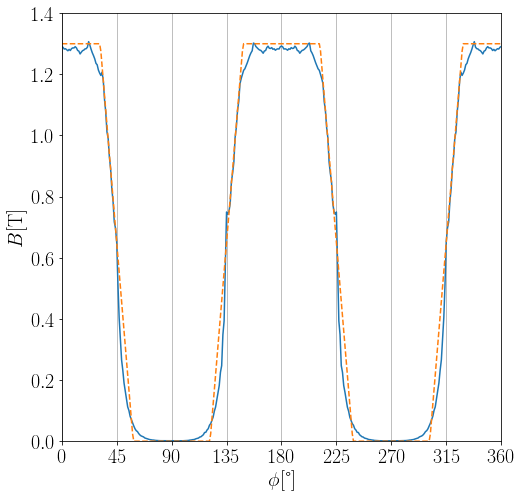

In [16]:
%%time
%matplotlib inline

B_high = 1.300
field_fraction = 0.35

alpha_B_rem_g_2, K_2 = optimize_and_plot_ramp(B_high,field_fraction,params_optimization_2)
print("Optimal angles:")
print(alpha_B_rem_g_2)
print("Value of the objective function:")
print(K_2)

### 1.400 T for 25% of the time

For this level of field we have to use a larger magnet (180 mm)).

In [18]:
params_optimization_3 = {"R_i": 0.015,
                "R_o": 0.060,
                "h_gap": FIXED_PARAMETERS_AMR["hgap[m]"],
                "R_s": 0.180,
                "h_fc": 0.010,
                "R_e": 0.3,
                "n_IV": 4,
                "phi_S_IV": 45,
                "n_II": 3,
                "phi_C_II": 15,
                "phi_S_II": 45,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

n_II = params_optimization_3["n_II"]
n_IV = params_optimization_3["n_IV"]

n = n_II + n_IV

B_rem = 1.4

# expand parameters to include remanence magnitudes for each segment
params_optimization_3 = teslamax.expand_parameters_from_remanence_array(B_rem*np.ones(n), 
                                                                      params_optimization_3, 
                                                                      "B_rem")




Optimal angles:
[  34.76202383   22.26081607  133.28236441    0.           27.96710451
   77.72856745  137.09578463]
Value of the objective function:
0.496940553316
Wall time: 34min 8s


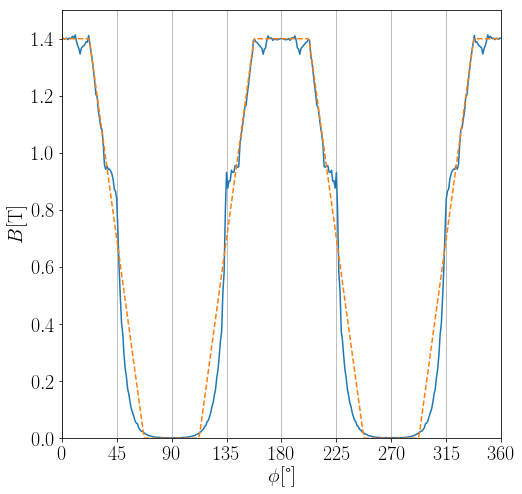

In [19]:
%%time
%matplotlib inline

B_high = 1.400
field_fraction = 0.25

alpha_B_rem_g_3, K_3 = optimize_and_plot_ramp(B_high,field_fraction,params_optimization_3)
print("Optimal angles:")
print(alpha_B_rem_g_3)
print("Value of the objective function:")
print(K_3)